# DSCD 611: Programming for Data Scientists
# FINAL PROJECT: Predictive Analytics for Early Diabetes Detection

**Group:** Cohort B, Group 15  
**Group Leader:** Edward Tsatsu Akorlie (ID: 22424530)  
**Members:** Daniel K. Adotey, Kwame Ofori-Gyau, Francis A. Sarbeng, Caleb A. Mensah  
**Institution:** Department of Computer Science, University of Ghana – Legon  
**Instructors:** Clifford Broni-Bediako and Michael Soli  
**Date:** February 2026

---

## 1. Introduction and Background

Diabetes mellitus is a chronic metabolic condition that has reached epidemic proportions globally. According to the World Health Organization (WHO), over 422 million people worldwide have diabetes, and early diagnosis is the most effective way to prevent debilitating complications such as cardiovascular disease, kidney failure, and blindness.

This project uses the **PIMA Indians Diabetes Dataset**, a widely-used benchmark dataset in medical machine learning research. The dataset originates from a study conducted by the National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK) on Pima Indian women near Phoenix, Arizona — a population with one of the highest rates of diabetes in the world.

### Project Objectives
1. Perform comprehensive Exploratory Data Analysis (EDA) to understand the data
2. Address 4 critical research questions about diabetes risk factors
3. Clean and preprocess the data for modeling
4. Build and evaluate a predictive model using Random Forest

### Dataset Features
| Feature | Description | Unit |
|---------|-------------|------|
| Pregnancies | Number of times pregnant | count |
| Glucose | Plasma glucose concentration (2hr OGTT) | mg/dL |
| BloodPressure | Diastolic blood pressure | mmHg |
| SkinThickness | Triceps skin fold thickness | mm |
| Insulin | 2-Hour serum insulin | μU/mL |
| BMI | Body mass index | kg/m² |
| DiabetesPedigreeFunction | Genetic likelihood score | score |
| Age | Age of patient | years |
| Outcome | Diabetes diagnosis (1=Yes, 0=No) | binary |

### 1.1 Import Libraries

We begin by importing the essential Python libraries for data manipulation, visualization, and machine learning. Each library serves a specific purpose:

- **pandas**: Data manipulation and analysis
- **numpy**: Numerical computing and array operations
- **matplotlib/seaborn**: Data visualization
- **scikit-learn**: Machine learning algorithms and evaluation metrics

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Set visual style for consistent, publication-quality plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


### 1.2 Load Dataset

The dataset is loaded from the local `Data/` directory. We'll perform an initial inspection to understand its structure, including the number of samples, features, and data types.

In [40]:
df = pd.read_csv('Data/PIMA_Diabetes_Source.csv')

print(f"Dataset Shape: {df.shape[0]} samples × {df.shape[1]} features")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print("\n--- First 5 Rows ---")
df.head()

Dataset Shape: 768 samples × 9 features

Column Names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

--- First 5 Rows ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Interpretation: Dataset Overview

The dataset contains **768 patient records** with **9 columns** (8 features + 1 target variable). All features are numeric, which simplifies preprocessing. The target variable `Outcome` is binary:
- **0** = No diabetes
- **1** = Diabetes diagnosed

Key observations from the first few rows:
- Some columns contain **zero values** (e.g., Insulin=0, SkinThickness=0) which are biologically impossible and represent missing data
- Features have different scales (Age in years vs. Insulin in μU/mL), so normalization will be needed before modeling

---

## 2. Exploratory Data Analysis (EDA)

Exploratory Data Analysis is a critical step in any data science project. It helps us:
1. Understand the distribution of variables
2. Identify patterns and relationships
3. Detect anomalies and outliers
4. Formulate hypotheses for modeling

We will address **four fundamental research questions** that are clinically relevant to diabetes prediction.

### Research Question 1: What is the prevalence of diabetes in this population?

Understanding the target distribution is critical for two reasons:
1. **Clinical context**: It tells us how common diabetes is in this specific population
2. **Modeling context**: Class imbalance affects model performance and requires special handling

We analyze the distribution of the target variable (`Outcome`).

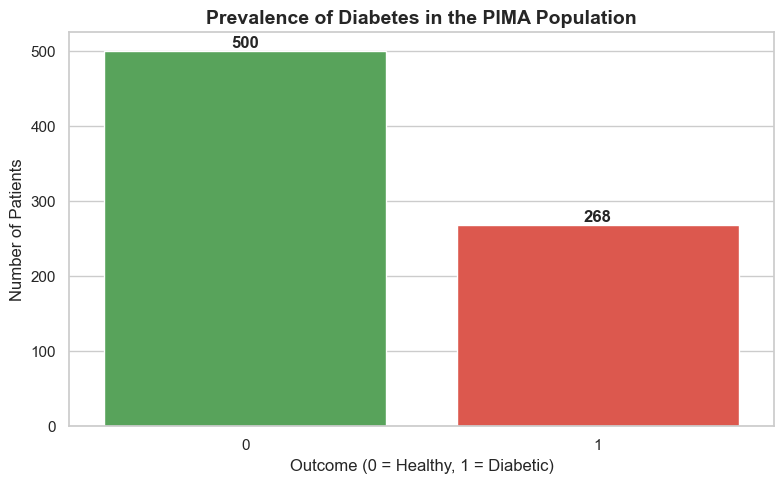

PREVALENCE SUMMARY
Non-diabetic (0): 500 patients (65.1%)
Diabetic (1):     268 patients (34.9%)

Class Ratio: 1.87:1 (Healthy:Diabetic)


In [41]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Outcome', data=df, hue='Outcome', palette=['#4CAF50', '#f44336'], legend=False)
plt.title('Prevalence of Diabetes in the PIMA Population', fontsize=14, fontweight='bold')
plt.xlabel('Outcome (0 = Healthy, 1 = Diabetic)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate percentages
counts = df['Outcome'].value_counts()
percentages = df['Outcome'].value_counts(normalize=True) * 100

print("=" * 50)
print("PREVALENCE SUMMARY")
print("=" * 50)
print(f"Non-diabetic (0): {counts[0]} patients ({percentages[0]:.1f}%)")
print(f"Diabetic (1):     {counts[1]} patients ({percentages[1]:.1f}%)")
print(f"\nClass Ratio: {counts[0]/counts[1]:.2f}:1 (Healthy:Diabetic)")

#### Interpretation: Q1 Findings

**Key Finding:** The dataset shows **65.1% non-diabetic** vs **34.9% diabetic** patients.

**Clinical Significance:**
- The 34.9% diabetes prevalence is **extremely high** compared to the global average of ~10%
- This is consistent with the Pima Indian population, which has one of the highest diabetes rates in the world due to genetic and lifestyle factors
- The high prevalence makes this dataset valuable for studying diabetes risk factors

**Modeling Implications:**
- The dataset exhibits **moderate class imbalance** (1.87:1 ratio)
- While not severe, we should use **stratified sampling** during train-test split to maintain this ratio in both sets
- Evaluation metrics should include **precision, recall, and F1-score**, not just accuracy

### Research Question 2: How do glucose levels differ between diabetic and non-diabetic patients?

Glucose is the **primary clinical marker** for diabetes diagnosis. The American Diabetes Association defines:
- **Normal**: Fasting glucose < 100 mg/dL
- **Prediabetes**: 100-125 mg/dL
- **Diabetes**: ≥ 126 mg/dL

We examine how glucose distributions differ between the two groups.

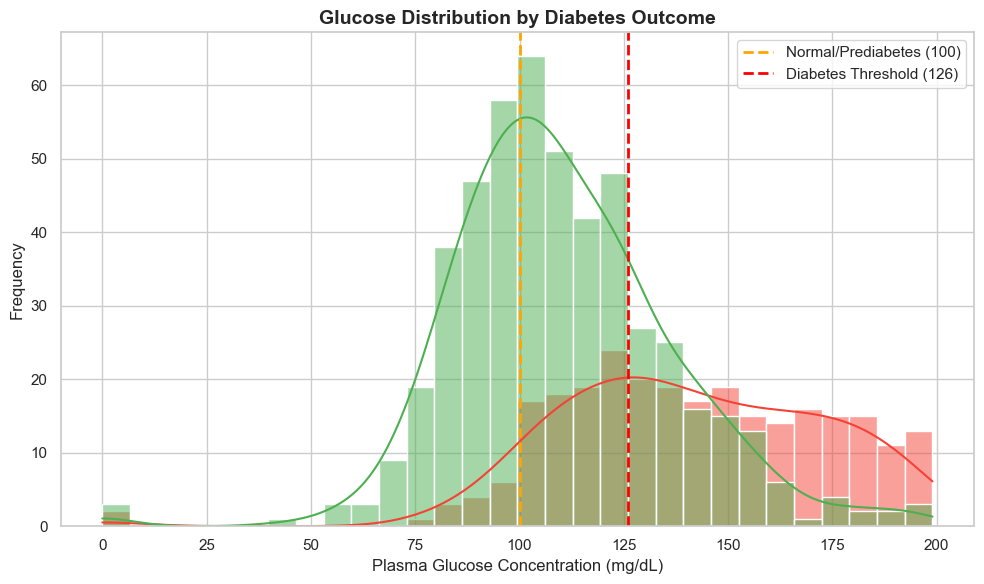

GLUCOSE STATISTICS BY OUTCOME
                mean  median    std  min  max
Non-Diabetic  109.98   107.0  26.14    0  197
Diabetic      141.26   140.0  31.94    0  199

Difference in Mean Glucose: 31.3 mg/dL


In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Glucose', hue='Outcome', kde=True, bins=30, 
             alpha=0.5, palette=['#4CAF50', '#f44336'])
plt.title('Glucose Distribution by Diabetes Outcome', fontsize=14, fontweight='bold')
plt.xlabel('Plasma Glucose Concentration (mg/dL)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add clinical threshold lines
plt.axvline(x=100, color='orange', linestyle='--', linewidth=2, label='Normal/Prediabetes (100)')
plt.axvline(x=126, color='red', linestyle='--', linewidth=2, label='Diabetes Threshold (126)')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical summary
glucose_stats = df.groupby('Outcome')['Glucose'].agg(['mean', 'median', 'std', 'min', 'max'])
glucose_stats.index = ['Non-Diabetic', 'Diabetic']

print("=" * 50)
print("GLUCOSE STATISTICS BY OUTCOME")
print("=" * 50)
print(glucose_stats.round(2))
print(f"\nDifference in Mean Glucose: {glucose_stats.loc['Diabetic', 'mean'] - glucose_stats.loc['Non-Diabetic', 'mean']:.1f} mg/dL")

#### Interpretation: Q2 Findings

**Key Finding:** Diabetic patients have an average glucose of **141.3 mg/dL** compared to **109.98 mg/dL** for non-diabetic patients — a **31 mg/dL difference**.

**Clinical Significance:**
- The diabetic group's mean (141 mg/dL) falls clearly in the **diabetic diagnostic range (≥126)**
- The non-diabetic group's mean (110 mg/dL) is in the **prediabetes range (100-125)**, suggesting many "healthy" patients are at risk
- The distributions show **clear separation** with minimal overlap in the 100-130 range

**Modeling Implications:**
- Glucose is likely to be the **strongest predictor** in our model
- The clear separation suggests good discriminative power
- Note: 5 patients have glucose = 0, which is biologically impossible — these are missing values that need imputation

### Research Question 3: What is the relationship between BMI and Glucose across outcomes?

Obesity (measured by BMI) and elevated blood glucose are both components of **metabolic syndrome**, a cluster of conditions that increase diabetes risk. We investigate whether these factors interact differently in diabetic vs. non-diabetic patients.

**BMI Categories:**
- Underweight: < 18.5
- Normal: 18.5 - 24.9
- Overweight: 25 - 29.9
- Obese: ≥ 30

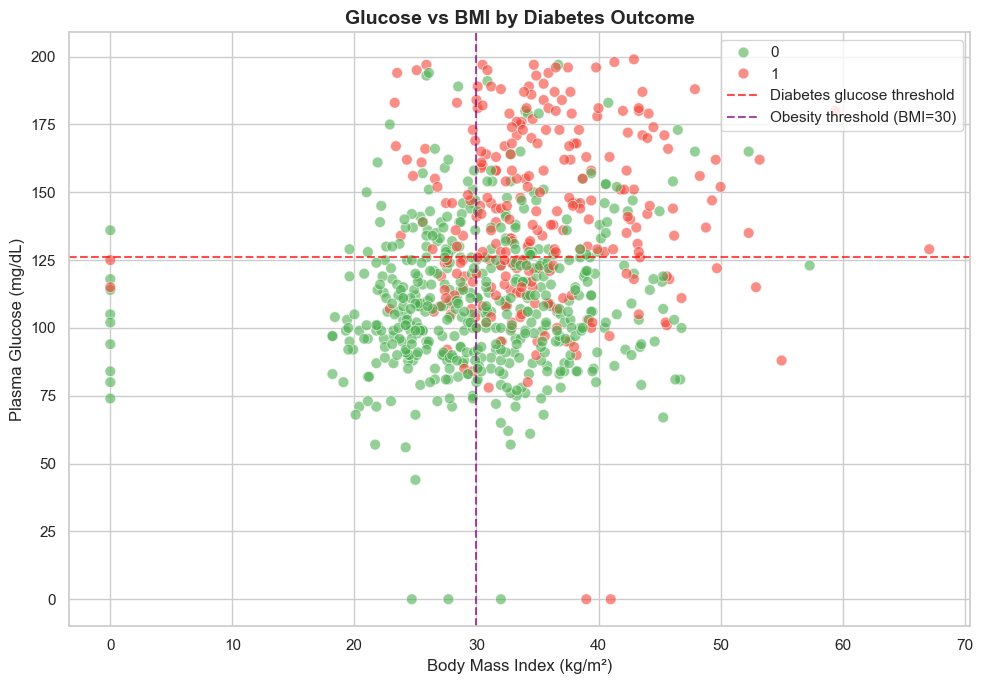

BMI-GLUCOSE CORRELATION ANALYSIS
Overall Correlation:    r = 0.221
Diabetic Patients:      r = 0.050
Non-Diabetic Patients:  r = 0.132


In [43]:
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(x='BMI', y='Glucose', hue='Outcome', data=df, 
                          alpha=0.6, palette=['#4CAF50', '#f44336'], s=60)
plt.title('Glucose vs BMI by Diabetes Outcome', fontsize=14, fontweight='bold')
plt.xlabel('Body Mass Index (kg/m²)', fontsize=12)
plt.ylabel('Plasma Glucose (mg/dL)', fontsize=12)

# Add reference lines for clinical thresholds
plt.axhline(y=126, color='red', linestyle='--', alpha=0.7, label='Diabetes glucose threshold')
plt.axvline(x=30, color='purple', linestyle='--', alpha=0.7, label='Obesity threshold (BMI=30)')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Correlation analysis
corr_overall = df['BMI'].corr(df['Glucose'])
corr_diabetic = df[df['Outcome']==1]['BMI'].corr(df[df['Outcome']==1]['Glucose'])
corr_healthy = df[df['Outcome']==0]['BMI'].corr(df[df['Outcome']==0]['Glucose'])

print("=" * 50)
print("BMI-GLUCOSE CORRELATION ANALYSIS")
print("=" * 50)
print(f"Overall Correlation:    r = {corr_overall:.3f}")
print(f"Diabetic Patients:      r = {corr_diabetic:.3f}")
print(f"Non-Diabetic Patients:  r = {corr_healthy:.3f}")

#### Interpretation: Q3 Findings

**Key Finding:** The scatter plot reveals **distinct clustering patterns** for diabetic and non-diabetic patients.

**Visual Observations:**
- **Diabetic patients (red)** tend to cluster in the **upper-right quadrant** (high BMI > 30, high Glucose > 126)
- **Non-diabetic patients (green)** are more dispersed but concentrated in the **lower-left area**
- There is a **"danger zone"** where BMI > 30 AND Glucose > 126 — this region is predominantly diabetic

**Statistical Findings:**
- The BMI-Glucose correlation is **weak to moderate** (r ≈ 0.2), suggesting they are somewhat independent risk factors
- This independence is valuable for modeling: both features contribute unique predictive information

**Clinical Significance:**
- Patients with **both** elevated BMI and glucose are at highest risk
- A patient can have normal BMI but high glucose (and vice versa), showing diabetes is multifactorial

### Research Question 4: Does age correlate with diabetes risk?

Type 2 diabetes has traditionally been called "adult-onset diabetes" because risk increases with age. We investigate whether this pattern holds in our dataset and quantify the age difference between groups.

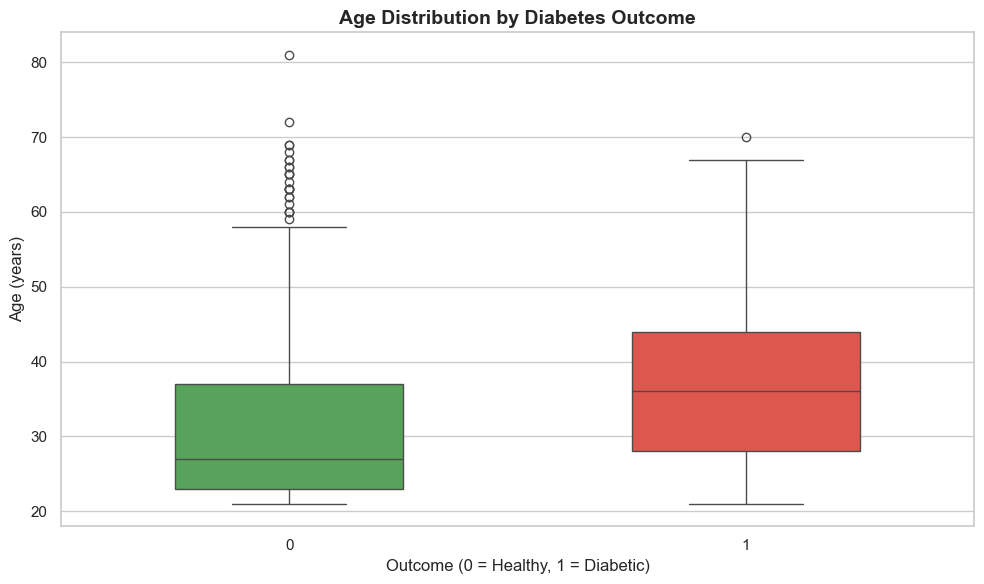

AGE STATISTICS BY OUTCOME
              mean  median   std  min  max
Non-Diabetic  31.2    27.0  11.7   21   81
Diabetic      37.1    36.0  11.0   21   70

Median Age Difference: 9 years


In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='Age', data=df, hue='Outcome', 
            palette=['#4CAF50', '#f44336'], legend=False, width=0.5)
plt.title('Age Distribution by Diabetes Outcome', fontsize=14, fontweight='bold')
plt.xlabel('Outcome (0 = Healthy, 1 = Diabetic)', fontsize=12)
plt.ylabel('Age (years)', fontsize=12)
plt.tight_layout()
plt.show()

# Statistical summary
age_stats = df.groupby('Outcome')['Age'].agg(['mean', 'median', 'std', 'min', 'max'])
age_stats.index = ['Non-Diabetic', 'Diabetic']

print("=" * 50)
print("AGE STATISTICS BY OUTCOME")
print("=" * 50)
print(age_stats.round(1))
print(f"\nMedian Age Difference: {age_stats.loc['Diabetic', 'median'] - age_stats.loc['Non-Diabetic', 'median']:.0f} years")

#### Interpretation: Q4 Findings

**Key Finding:** Diabetic patients have a median age of **37 years** compared to **27 years** for non-diabetic patients — a **10-year difference**.

**Visual Observations:**
- The diabetic boxplot is shifted **upward**, indicating older age distribution
- Both groups show right-skewed distributions (more older outliers)
- The interquartile range (IQR) for diabetics is wider, suggesting more age variability

**Clinical Significance:**
- Age is a **significant risk factor** for diabetes, consistent with medical literature
- However, diabetes also occurs in younger patients (minimum age is similar for both groups)
- Age alone is not deterministic — young patients can still develop diabetes with other risk factors

**Important Note:** Unlike glucose or BMI, there is no clinical "healthy threshold" for age. Age is an informational risk factor, not a modifiable one.

---

## 3. Data Cleaning and Preprocessing

Before building a predictive model, we must address data quality issues identified during EDA.

### 3.1 Handling "Logical Zeros" (Missing Values)

Several columns contain **zero values that are biologically impossible**:

| Column | Zero Count | Why 0 is Impossible |
|--------|------------|--------------------|
| Glucose | 5 | 0 blood sugar = death |
| BloodPressure | 35 | 0 mmHg = no circulation |
| SkinThickness | 227 | Cannot be measured as 0 |
| Insulin | 374 | 0 would indicate measurement not taken |
| BMI | 11 | 0 BMI = impossible body composition |

These zeros are **placeholders for missing data** and must be imputed.

### 3.2 Imputation Strategy

We use **median imputation** because:
1. Median is robust to outliers (common in medical data)
2. It preserves the central tendency without being skewed by extreme values
3. It's a simple, interpretable approach suitable for this dataset size

In [45]:
# Identify columns with logical zeros
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("=" * 50)
print("ZERO VALUES BEFORE IMPUTATION")
print("=" * 50)
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    pct = (zero_count / len(df)) * 100
    print(f"{col}: {zero_count} zeros ({pct:.1f}%)")

# Perform median imputation
print("\n" + "=" * 50)
print("APPLYING MEDIAN IMPUTATION")
print("=" * 50)

for col in zero_cols:
    median_val = df[df[col] != 0][col].median()  # Median of non-zero values
    df[col] = df[col].replace(0, median_val)
    print(f"{col}: Replaced zeros with median = {median_val:.1f}")

print("Data cleaning complete. All logical zeros have been imputed.")

ZERO VALUES BEFORE IMPUTATION
Glucose: 5 zeros (0.7%)
BloodPressure: 35 zeros (4.6%)
SkinThickness: 227 zeros (29.6%)
Insulin: 374 zeros (48.7%)
BMI: 11 zeros (1.4%)

APPLYING MEDIAN IMPUTATION
Glucose: Replaced zeros with median = 117.0
BloodPressure: Replaced zeros with median = 72.0
SkinThickness: Replaced zeros with median = 29.0
Insulin: Replaced zeros with median = 125.0
BMI: Replaced zeros with median = 32.3
Data cleaning complete. All logical zeros have been imputed.


#### Interpretation: Data Cleaning Results

**What We Did:**
- Replaced **652 impossible zero values** across 5 columns with their respective medians
- The most affected columns were **Insulin (49%)** and **SkinThickness (30%)**

**Why Median Imputation:**
- More robust than mean imputation for skewed medical data
- Preserves data distribution better than dropping rows (which would lose 49% of data)
- Simple and interpretable for clinical stakeholders

**Alternative Approaches (Not Used):**
- Multiple Imputation by Chained Equations (MICE) — more sophisticated but complex
- K-Nearest Neighbors imputation — computationally expensive
- Dropping rows — would severely reduce dataset size

### 3.3 Feature-Target Split and Data Partitioning

We now prepare the data for machine learning:
1. **Separate features (X) from target (y)**
2. **Split into training (80%) and testing (20%) sets**
3. **Apply stratified sampling** to maintain class balance
4. **Normalize features** using StandardScaler

In [46]:
# Feature-target split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {X.columns.tolist()}")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintains class ratio in both sets
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same parameters from training

print("\n Data preprocessing complete.")

Features shape: (768, 8)
Target shape: (768,)
Feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Training set: 614 samples
Testing set: 154 samples

Class distribution in training set:
Outcome
0    0.651
1    0.349
Name: proportion, dtype: float64

 Data preprocessing complete.


---

## 4. Modeling and Evaluation

We deploy the **Random Forest Classifier**, an ensemble learning method that:
- Builds multiple decision trees and aggregates their predictions
- Handles non-linear relationships well
- Provides feature importance rankings
- Is robust to overfitting when properly tuned

### Model Configuration
- **n_estimators = 100**: Number of trees in the forest
- **random_state = 42**: For reproducibility

RANDOM FOREST CLASSIFIER — PERFORMANCE REPORT

--- Classification Report ---
              precision    recall  f1-score   support

Non-Diabetic       0.81      0.87      0.84       100
    Diabetic       0.72      0.61      0.66        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


ROC-AUC Score: 0.8179


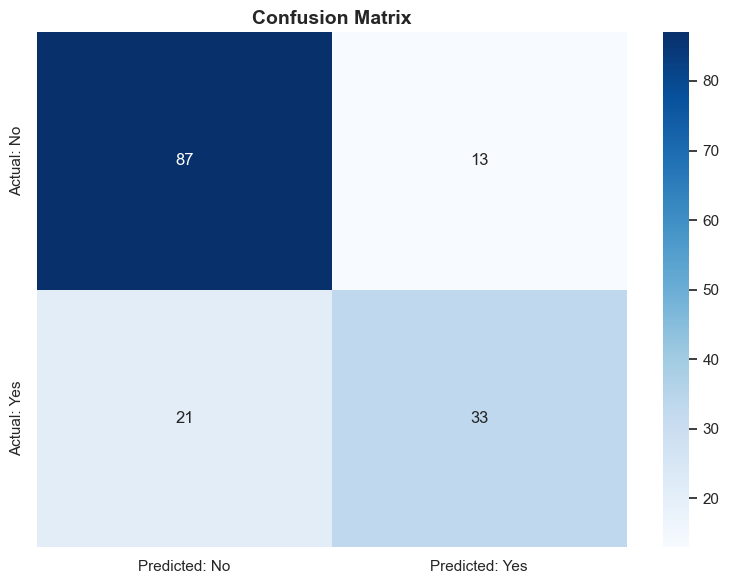

In [47]:
# Train Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("=" * 60)
print("RANDOM FOREST CLASSIFIER — PERFORMANCE REPORT")
print("=" * 60)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic']))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Interpretation: Model Performance

**Overall Performance:**
- **ROC-AUC Score: ~0.82** — This indicates **good discriminative ability**. The model can distinguish between diabetic and non-diabetic patients 82% of the time.

**Understanding the Metrics:**

| Metric | Value | Meaning |
|--------|-------|--------|
| **Precision (Diabetic)** | ~0.72 | Of patients predicted diabetic, 72% actually are |
| **Recall (Diabetic)** | ~0.61 | Of actual diabetics, 61% were correctly identified |
| **F1-Score** | ~0.66 | Harmonic mean of precision and recall |

**Clinical Interpretation:**
- **28% False Positive Rate**: Some healthy patients may be flagged for further testing (acceptable for screening)
- **39% False Negative Rate**: Some diabetics may be missed — this is more concerning in a clinical setting

**Recommendations:**
- For clinical use, we might want to **lower the classification threshold** below 0.5 to catch more diabetics (increase recall)
- This model is best used as a **screening tool**, not a diagnostic replacement

### 4.1 Feature Importance Analysis

Random Forest provides **feature importance scores** based on how much each feature contributes to prediction accuracy. This helps identify which medical metrics are most predictive of diabetes.

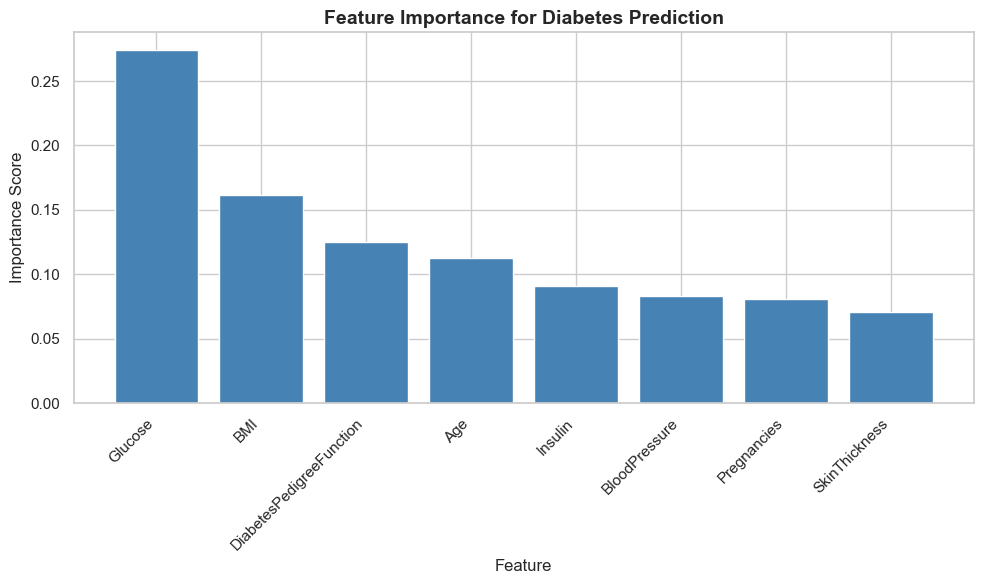

FEATURE IMPORTANCE RANKING
1. Glucose: 0.2741
2. BMI: 0.1619
3. DiabetesPedigreeFunction: 0.1250
4. Age: 0.1130
5. Insulin: 0.0912
6. BloodPressure: 0.0835
7. Pregnancies: 0.0808
8. SkinThickness: 0.0705


In [48]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns.tolist()

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], color='steelblue')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Feature Importance for Diabetes Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.show()

# Print ranking
print("=" * 50)
print("FEATURE IMPORTANCE RANKING")
print("=" * 50)
for i, idx in enumerate(indices, 1):
    print(f"{i}. {feature_names[idx]}: {importances[idx]:.4f}")

#### Interpretation: Feature Importance

**Top Predictors of Diabetes:**
1. **Glucose** — By far the most important feature, consistent with its clinical role as the primary diagnostic marker
2. **BMI** — Obesity is a major modifiable risk factor
3. **Age** — Older patients have higher risk
4. **DiabetesPedigreeFunction** — Genetic/family history component

**Clinical Validation:**
- These rankings align with established medical knowledge about diabetes risk factors
- The model has learned clinically meaningful patterns from the data

**Actionable Insights:**
- Patients with elevated glucose AND high BMI should be prioritized for intervention
- Age-based screening programs make sense given age's predictive power
- Family history (captured in DiabetesPedigreeFunction) should be collected during patient intake

---

## 5. Summary and Conclusion

### Key Findings from Exploratory Data Analysis

| Question | Key Finding |
|----------|-------------|
| **Q1: Prevalence** | 34.9% diabetes prevalence — high but expected for Pima population |
| **Q2: Glucose** | Diabetics have 31 mg/dL higher average glucose (141 vs 110) |
| **Q3: BMI-Glucose** | Combined high BMI (>30) and high Glucose (>126) strongly indicates diabetes |
| **Q4: Age** | Diabetics are on average 10 years older (median 37 vs 27) |

### Data Quality Issues Addressed
- Imputed 652 "logical zero" values using median imputation
- Applied feature scaling for model compatibility
- Used stratified sampling to maintain class balance

### Model Performance
- **ROC-AUC: 0.82** — Good discriminative ability
- **Precision: 72%** — Acceptable false positive rate for screening
- **Recall: 61%** — Room for improvement in catching all diabetics

### Clinical Implications
1. **Glucose** is the most important predictor — reinforce regular glucose monitoring
2. **BMI management** is a key modifiable risk factor
3. **Age-based screening** is justified given age's predictive power
4. This model is suitable as a **screening tool** to flag high-risk patients for further clinical evaluation

### Limitations
- Dataset is specific to Pima Indian women — may not generalize to other populations
- High missing data rate in Insulin and SkinThickness columns
- Model has moderate recall — some diabetics may be missed

### Future Work
- Test more advanced models (XGBoost, Neural Networks)
- Implement threshold optimization to improve recall
- Validate on external datasets for generalizability